In [175]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 21 11:34:56 2020

@author: Wazowskai
"""

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt



#problem constants
nu=1e-6
mu=1e-3
rho=1e+3
dt=0.00001
gradP=-2.4
n_iter=0
'''
node generation section
'''
#domain length

Lx1=0.02
Lx2=0.01

r_dpl=0.25*Lx2
#number of cells on each direction
Nx1=120
Nx2=60

cell_vol=(Lx1/Nx1)*(Lx2/Nx2)

#mesh spacing
h=Lx1/Nx1

#uave
u1_ave=0.02
cell_vol=(Lx1/Nx1)*(Lx2/Nx2)

#mesh spacing
h=Lx1/Nx1

def Adv_x_n(i,j):
    return (1/h)*((0.5*(cell_S_x_un[i,j]+cell_S_x_un[i+1,j]))**2-(0.5*(cell_S_x_un[i,j]+cell_S_x_un[i-1,j]))**2+(0.5*(cell_S_x_un[i,j+1]+cell_S_x_un[i,j]))*(cell_S_y_vn[i,j+1]+cell_S_y_vn[i+1,j+1])-(0.5*(cell_S_x_un[i,j]+cell_S_x_un[i,j-1]))*(0.5*(cell_S_y_vn[i,j]+cell_S_y_vn[i+1,j]))) 

def Dif_x_n(i,j):
    return (1/(h**2))*(cell_S_x_un[i+1,j]+cell_S_x_un[i-1,j]+cell_S_x_un[i,j+1]+cell_S_x_un[i,j-1]-4*cell_S_x_un[i,j])

def Dif_y_n(i,j):
    return (1/(h**2))*(cell_S_y_vn[i+1,j]+cell_S_y_vn[i-1,j]+cell_S_y_vn[i,j+1]+cell_S_y_vn[i,j-1]-4*cell_S_y_vn[i,j])

def ref_vel_prof(x2):
    '''
    function returning reference analytic sol
    '''
    return -1200*((x2-0.005)**2)+0.03

def lvlset_init(x,y):
    def ls_dpl(x,y):
        return -1*(math.sqrt((x-0.01)**2+(y-0.005)**2)-r_dpl)
    return ls_dpl(x,y)

def M_sw(a,b):
    return a if abs(a)<abs(b) else b
#level-set functions
                                                                                #Differences for L_phi_n #Operator Defined in 3.43
def D_x_p_n(i,j):                                                             #Eq 3.46 Implementing Differences
    if i==Nx1+1:
        return cell_cent_phin[2,j]-cell_cent_phin[i,j]                      
    else:    
        return cell_cent_phin[i+1,j]-cell_cent_phin[i,j]                        #Dx_plus

def D_x_m_n(i,j):
    return cell_cent_phin[i,j]-cell_cent_phin[i-1,j]                            #Dx_minus

def D_y_p_n(i,j):
    return cell_cent_phin[i,j+1]-cell_cent_phin[i,j]                            #Dy_plus

def D_y_m_n(i,j):
    return cell_cent_phin[i,j]-cell_cent_phin[i-1,j]                            #Dy_minus

                                                                                #Differences for L_phi_star #Operator Defined in 3.43                        
def D_x_p_s(i,j):                                                               #Eq 3.46 Implementing Differences
    if i==Nx1+1:
        return cell_cent_phis[2,j]-cell_cent_phis[i,j]                          #Dx_plus
    else:                                                                       
        return cell_cent_phis[i+1,j]-cell_cent_phis[i,j]                     

def D_x_m_s(i,j):       
    return cell_cent_phis[i,j]-cell_cent_phis[i-1,j]                            #Dx_minus

def D_y_p_s(i,j):                                                               #Dy_plus
    return cell_cent_phis[i,j+1]-cell_cent_phis[i,j]                   

def D_y_m_s(i,j):                                                               #Dy_minus
    return cell_cent_phis[i,j]-cell_cent_phis[i-1,j]

def L_phi_n(i,j):                                                               #Eq 3.43 L_phi Operator

    def phi_xh_n(i,j):                                                          #For i+1/2,j Eq 3.44
        if 0.5*(cell_S_x_unn[i+1,j]+cell_S_x_unn[i,j])>0:
            return cell_cent_phin[i,j]+0.5*M_sw(D_x_p_n(i,j), D_x_m_n(i,j))
        elif 0.5*(cell_S_x_unn[i+1,j]+cell_S_x_unn[i,j])<0:
            return cell_cent_phin[i+1,j]-0.5*M_sw(D_x_p_n(i+1,j), D_x_m_n(i+1,j))
            
    def phi_hx_n(i,j):                                                          #For i-1/2,j Eq 3.44
        if 0.5*(cell_S_x_unn[i,j]+cell_S_x_unn[i-1,j])<0:
            return cell_cent_phin[i,j]-0.5*M_sw(D_x_p_n(i,j), D_x_m_n(i,j)) 
        elif 0.5*(cell_S_x_unn[i,j]+cell_S_x_unn[i-1,j])>0:
            return cell_cent_phin[i-1,j]+0.5*M_sw(D_x_p_n(i-1,j), D_x_m_n(i-1,j))
        
    # def phi_yh_n(i,j):                                                          #For i,j+1/2 Eq 3.44
    #     if 0.5*(cell_S_y_vnn[i,j+1]+cell_S_y_vnn[i,j])>0:
    #         return cell_cent_phin[i,j]+0.5*M_sw(D_y_p_n(i.j), D_y_m_n(i,j))
    #     elif 0.5*(cell_S_y_vnn[i,j+1]+cell_S_y_vnn[i,j])<0:
    #         return cell_cent_phin[i,j+1]+0.5*M_sw(D_y_p_n(i,j+1), D_y_m_n(i,j+1))
        
    # def phi_hy_n(i,j):                                                          #For i,j-1/2 Eq 3.44
    #     if 0.5*(cell_S_y_vnn[i,j]+cell_S_y_vnn[i,j-1])<0:
    #         return cell_cent_phin[i,j]-0.5*M_sw(D_y_p_n(i,j), D_y_m_n(i,j))
    #     elif 0.5*(cell_S_y_vnn[i,j]+cell_S_y_vnn[i,j-1])>0:
    #         return cell_cent_phin[i,j-1]+0.5*M_sw(D_y_p_n(i,j-1), D_y_m_n(i,j-1))
   
    #return -1*(cell_S_x_unn[i,j])*(phi_xh_n(i,j)-phi_hx_n(i,j))/h-(cell_S_y_vnn[i,j])*(phi_yh_n(i,j)-phi_hy_n(i,j))/h
    return -1*(cell_S_x_unn[i,j])*(phi_xh_n(i,j)-phi_hx_n(i,j))/h               #Eq 3.43 (L_phi_n)


def L_phi_s(i,j):                                                               #Eq 3.43 L_phi_star Operator

    def phi_xh_s(i,j):                                                          #For i+1/2,j Eq 3.44
        if 0.5*(cell_S_x_unn[i+1,j]+cell_S_x_unn[i,j])>0:
            return cell_cent_phis[i,j]+0.5*M_sw(D_x_p_s(i,j), D_x_m_s(i,j))     
        elif 0.5*(cell_S_x_unn[i+1,j]+cell_S_x_unn[i,j])<0:
            return cell_cent_phis[i+1,j]-0.5*M_sw(D_x_p_s(i+1,j), D_x_p_s(i+1,j))
            
    def phi_hx_s(i,j):                                                          #For i-1/2,j Eq 3.44
        if 0.5*(cell_S_x_unn[i,j]+cell_S_x_unn[i-1,j])<0:
            return cell_cent_phis[i,j]-0.5*M_sw(D_x_p_s(i,j), D_x_m_s(i,j)) 
        elif 0.5*(cell_S_x_unn[i,j]+cell_S_x_unn[i-1,j])>0:
            return cell_cent_phis[i-1,j]+0.5*M_sw(D_x_p_s(i-1,j), D_x_m_s(i-1,j))
        
    # def phi_yh_s(i,j):                                                          #For i,,j+1/2 Eq 3.44
    #     if 0.5*(cell_S_y_vnn[i,j+1]+cell_S_y_vnn[i,j])>0:
    #         return cell_cent_phis[i,j]+0.5*M_sw(D_y_p_s(i.j), D_y_m_s(i,j))
    #     elif 0.5*(cell_S_y_vnn[i,j+1]+cell_S_y_vnn[i,j])<0:
    #         return cell_cent_phis[i,j+1]+0.5*M_sw(D_y_p_s(i,j+1), D_y_m_s(i,j+1))
        
    # def phi_hy_s(i,j):                                                          #For i,j-1/2 Eq 3.44
    #     if 0.5*(cell_S_y_vnn[i,j]+cell_S_y_vnn[i,j-1])<0:
    #         return cell_cent_phis[i,j]-0.5*M_sw(D_y_p_s(i,j), D_y_m_s(i,j))
    #     elif 0.5*(cell_S_y_vnn[i,j]+cell_S_y_vnn[i,j-1])>0:
    #         return cell_cent_phis[i,j-1]+0.5*M_sw(D_y_p_s(i,j-1), D_y_m_s(i,j-1))
    #return -1*(cell_S_x_unn[i,j])*(phi_xh_s(i,j)-phi_hx_s(i,j))/h-(cell_S_y_vnn[i,j])*(phi_yh_s(i,j)-phi_hy_s(i,j))/h
    return -1*(cell_S_x_unn[i,j])*(phi_xh_s(i,j)-phi_hx_s(i,j))/h               #Eq 3.43 (L_phi_star)

#redistancing functions

def sign_phi_Mh(i,j):                                                           #Eq 3.53
    if cell_cent_phin[i,j]>=(M*h):
        return 1
    elif cell_cent_phin[i,j]<=(-1*M*h):
        return -1
    else:
        return cell_cent_phin[i,j]/(M*h)-math.sin((math.pi*cell_cent_phin[i,j])/(M*h))/math.pi

def sign_phi(i,j):                                                              #Eq 3.48 Condition
    if cell_cent_phin[i,j]>0:
        return 1
    elif cell_cent_phin[i,j]<0:
        return -1
    else:
        return 0
    
   
def Dd_x_p_n(i,j):                                                              
    return cell_cent_phi_dn[i+1,j]-cell_cent_phi_dn[i,j]

def Dd_x_m_n(i,j):
    return cell_cent_phi_dn[i,j]-cell_cent_phi_dn[i-1,j]

def Dd_y_p_n(i,j):
    return cell_cent_phi_dn[i,j+1]-cell_cent_phi_dn[i,j]

def Dd_y_m_n(i,j):
    return cell_cent_phi_dn[i,j]-cell_cent_phi_dn[i,j-1]


def DDd_pm_x_n(i,j):                                                                                            #Assignment Problem 6.3
    if i==Nx1+1:    
        return cell_cent_phi_dn[2,j]-2*cell_cent_phi_dn[i,j]+cell_cent_phi_dn[i-1,j]
    elif i==0:
        return cell_cent_phi_dn[i+1,j]-2*cell_cent_phi_dn[i,j]+cell_cent_phi_dn[-3,j]
    else:
        return cell_cent_phi_dn[i+1,j]-2*cell_cent_phi_dn[i,j]+cell_cent_phi_dn[i-1,j]

def DDd_pm_y_n(i,j):                                                                                            #Assignment Problem 6.3
    if j==Nx2+1:
        return cell_cent_phi_dn[i,2]-2*cell_cent_phi_dn[i,1]+cell_cent_phi_dn[i,0]
    elif j==0:
        return cell_cent_phi_dn[i,-1]-2*cell_cent_phi_dn[i,-2]+cell_cent_phi_dn[i,-3]
    else:
        return cell_cent_phi_dn[i,j+1]-2*cell_cent_phi_dn[i,j]+cell_cent_phi_dn[i,j-1]



def Dtda_x_p_n(i,j):
    return Dd_x_p_n(i,j)-0.5*M_sw(DDd_pm_x_n(i,j), DDd_pm_x_n(i+1,j))                           #Eq 3.52

def Dtda_x_m_n(i,j):
    return Dd_x_m_n(i,j)+0.5*M_sw(DDd_pm_x_n(i,j), DDd_pm_x_n(i-1,j))                           #Eq 3.52

def Dtda_y_p_n(i,j):
    return Dd_y_p_n(i,j)-0.5*M_sw(DDd_pm_y_n(i,j), DDd_pm_y_n(i+1,j))                           #Eq 3.52

def Dtda_y_m_n(i,j):
    return Dd_y_m_n(i,j)+0.5*M_sw(DDd_pm_y_n(i,j), DDd_pm_y_n(i-1,j))                           #Eq 3.52


def Dtda_x_n(i,j):                                                                              #Eq 3.51
    if (sign_phi(i,j)*Dd_x_p_n(i,j)<0) and (sign_phi(i,j)*Dd_x_m_n(i,j)<-1*sign_phi(i,j)*Dd_x_p_n(i,j)):
        return Dtda_x_p_n(i,j)
    elif(sign_phi(i,j)*Dd_x_m_n(i,j)<0) and (sign_phi(i,j)*Dd_x_p_n(i,j)>-1*sign_phi(i,j)*Dd_x_m_n(i,j)):
        return Dtda_x_m_n(i,j)
    else:
        return 0.5*(Dtda_x_p_n(i,j)+Dtda_x_m_n(i,j))  

def Dtda_y_n(i,j):                                                                              #Eq 3.51
    if (sign_phi(i,j)*Dd_y_p_n(i,j)<0) and (sign_phi(i,j)*Dd_y_m_n(i,j)<-1*sign_phi(i,j)*Dd_y_p_n(i,j)):
        return Dtda_y_p_n(i,j)
    elif (sign_phi(i,j)*Dd_y_m_n(i,j)<0) and (sign_phi(i,j)*Dd_y_p_n(i,j)>-1*sign_phi(i,j)*Dd_y_m_n(i,j)):
        return Dtda_y_m_n(i,j)
    else:
        return 0.5*(Dtda_y_p_n(i,j)+Dtda_y_m_n(i,j))
    
def L_phi_d_n(i,j):                                                                              #Eq 3.50
    return sign_phi_Mh(i,j)*(1-((Dtda_x_n(i,j)/h)**2+(Dtda_y_n(i,j)/h)**2)**0.5)

                                                       #Following the same process for Star

def Dd_x_p_s(i,j):
    return cell_cent_phi_ds[i+1,j]-cell_cent_phi_ds[i,j]                                         

def Dd_x_m_s(i,j):
    return cell_cent_phi_ds[i,j]-cell_cent_phi_ds[i-1,j]                                        

def Dd_y_p_s(i,j):
    return cell_cent_phi_ds[i,j+1]-cell_cent_phi_ds[i,j]

def Dd_y_m_s(i,j):
    return cell_cent_phi_ds[i,j]-cell_cent_phi_ds[i,j-1]

def DDd_pm_x_s(i,j):                                                                    #Assignment 6.3
    if i==Nx1+1:
        return cell_cent_phi_ds[2,j]-2*cell_cent_phi_ds[i,j]+cell_cent_phi_ds[i-1,j]
    elif i==0:
        return cell_cent_phi_ds[i+1,j]-2*cell_cent_phi_ds[i,j]+cell_cent_phi_ds[-3,j]
    else:
        return cell_cent_phi_ds[i+1,j]-2*cell_cent_phi_ds[i,j]+cell_cent_phi_ds[i-1,j]

def DDd_pm_y_s(i,j):                                                                    #Assignment 6.3
    if i==Nx1+1:
        return cell_cent_phi_ds[2,j]-2*cell_cent_phi_ds[i,j]+cell_cent_phi_ds[i-1,j]
    elif i==0:
        return cell_cent_phi_ds[i+1,j]-2*cell_cent_phi_ds[i,j]+cell_cent_phi_ds[-3,j]
    else:
        return cell_cent_phi_ds[i,j+1]-2*cell_cent_phi_ds[i,j]+cell_cent_phi_ds[i,j-1]

        

def Dtda_x_p_s(i,j):                                                                            #Eq 3.52 
    return Dd_x_p_s(i,j)-0.5*M_sw(DDd_pm_x_s(i,j), DDd_pm_x_s(i+1,j)) 

def Dtda_x_m_s(i,j):                                                                            #Eq 3.52 
    return Dd_x_m_s(i,j)+0.5*M_sw(DDd_pm_x_s(i,j), DDd_pm_x_s(i-1,j))

def Dtda_y_p_s(i,j):                                                                            #Eq 3.52 
    return Dd_y_p_s(i,j)-0.5*M_sw(DDd_pm_y_s(i,j), DDd_pm_y_s(i+1,j))

def Dtda_y_m_s(i,j):                                                                            #Eq 3.52 
    return Dd_y_m_s(i,j)+0.5*M_sw(DDd_pm_y_s(i,j), DDd_pm_y_s(i-1,j))


def Dtda_x_s(i,j):                                                                              #Eq 3.51 
    if (sign_phi(i,j)*Dd_x_p_s(i,j)<0) and (sign_phi(i,j)*Dd_x_m_s(i,j)<-1*sign_phi(i,j)*Dd_x_p_s(i,j)):
        return Dtda_x_p_s(i,j)
    elif(sign_phi(i,j)*Dd_x_m_s(i,j)<0) and (sign_phi(i,j)*Dd_x_p_s(i,j)>-1*sign_phi(i,j)*Dd_x_m_s(i,j)):
        return Dtda_x_m_s(i,j)
    else:
        return 0.5*(Dtda_x_p_s(i,j)+Dtda_x_m_s(i,j))  

def Dtda_y_s(i,j):                                                                              #Eq 3.52 
    if (sign_phi(i,j)*Dd_y_p_s(i,j)<0) and (sign_phi(i,j)*Dd_y_m_s(i,j)<-1*sign_phi(i,j)*Dd_y_p_s(i,j)):
        return Dtda_y_p_s(i,j)
    elif (sign_phi(i,j)*Dd_y_m_s(i,j)<0) and (sign_phi(i,j)*Dd_y_p_s(i,j)>-1*sign_phi(i,j)*Dd_y_m_s(i,j)):
        return Dtda_y_m_s(i,j)
    else:
        return 0.5*(Dtda_y_p_s(i,j)+Dtda_y_m_s(i,j))
    
    
def L_phi_d_s(i,j):                                                                             #Eq 3.50
    return sign_phi_Mh(i,j)*(1-((Dtda_x_s(i,j)/h)**2+(Dtda_y_s(i,j)/h)**2)**0.5)    


def grad_phi_xhpp(i,j):                                             #Eq 3.56 for Phi_i+1/2,j+1/2 (Phi_x)
    return (cell_cent_phin[i+1,j+1]+cell_cent_phin[i+1,j]-cell_cent_phin[i,j+1]-cell_cent_phin[i,j])/(2*h)

def grad_phi_xhpm(i,j):                                             #Eq 3.56 for Phi_i+1/2,j-1/2  (Phi_x)
    return (cell_cent_phin[i+1,j]+cell_cent_phin[i+1,j-1]-cell_cent_phin[i,j]-cell_cent_phin[i,j-1])/(2*h)

def grad_phi_xhmp(i,j):                                             #Eq 3.56 for Phi_i-1/2,j+1/2  (Phi_x)
    return (cell_cent_phin[i,j+1]+cell_cent_phin[i,j]-cell_cent_phin[i-1,j+1]-cell_cent_phin[i-1,j])/(2*h)

def grad_phi_xhmm(i,j):                                             #Eq 3.56 for Phi_i-1/2,j-1/2  (Phi_x)
    return (cell_cent_phin[i,j]+cell_cent_phin[i,j-1]-cell_cent_phin[i-1,j]-cell_cent_phin[i-1,j-1])/(2*h)
                        

def grad_phi_yhpp(i,j):                                             #Eq 3.56 for Phi_i+1/2,j+1/2 (Phi_y)
    return (cell_cent_phin[i+1,j+1]-cell_cent_phin[i+1,j]+cell_cent_phin[i,j+1]-cell_cent_phin[i,j])/(2*h)

def grad_phi_yhpm(i,j):                                             #Eq 3.56 for Phi_i+1/2,j-1/2  (Phi_y)
    return (cell_cent_phin[i+1,j]-cell_cent_phin[i+1,j-1]+cell_cent_phin[i,j]-cell_cent_phin[i,j-1])/(2*h)

def grad_phi_yhmp(i,j):                                             #Eq 3.56 for Phi_i-1/2,j+1/2  (Phi_y)
    return (cell_cent_phin[i,j+1]-cell_cent_phin[i,j]+cell_cent_phin[i-1,j+1]-cell_cent_phin[i-1,j])/(2*h)

def grad_phi_yhmm(i,j):                                             #Eq 3.56 for Phi_i-1/2,j-1/2  (Phi_y)
    return (cell_cent_phin[i,j]-cell_cent_phin[i,j-1]+cell_cent_phin[i-1,j]+cell_cent_phin[i-1,j-1])/(2*h)

def grad_phi_mag_hpp(i,j):
    return (grad_phi_xhpp(i,j)**2+grad_phi_yhpp(i,j)**2)**0.5       # Taking Magnitude for Phi_i+1/2,j+1/2

def grad_phi_mag_hpm(i,j):
    return (grad_phi_xhpm(i,j)**2+grad_phi_yhpm(i,j)**2)**0.5       # Taking Magnitude for Phi_i+1/2,j-1/2

def grad_phi_mag_hmp(i,j):
    return (grad_phi_xhmp(i,j)**2+grad_phi_yhmp(i,j)**2)**0.5        # Taking Magnitude for Phi_i-1/2,j+1/2

def grad_phi_mag_hmm(i,j):
    return (grad_phi_xhmm(i,j)**2+grad_phi_yhmm(i,j)**2)**0.5       # Taking Magnitude for Phi_i-1/2,j-1/2

def kappa(i,j):                                                     # Implementing 3.56
    return ((grad_phi_xhpp(i,j)/grad_phi_mag_hpp(i,j))+(grad_phi_xhpm(i,j)/grad_phi_mag_hpm(i,j))-(grad_phi_xhmp(i,j)/grad_phi_mag_hmp(i,j))-(grad_phi_xhmm(i,j)/grad_phi_mag_hmm(i,j))+(grad_phi_yhpp(i,j)/grad_phi_mag_hpp(i,j))-(grad_phi_yhpm(i,j)/grad_phi_mag_hpm(i,j))+(grad_phi_yhmp(i,j)/grad_phi_mag_hmp(i,j))-(grad_phi_yhmm(i,j)/grad_phi_mag_hmm(i,j)))


def dfdphi(i,j):                                                     # Derivative of Eq 3.54
    if cell_cent_phin[i,j]<-1*M*h or cell_cent_phin[i,j]>M*h:
        return 0
    else:
        return (1+math.cos((math.pi*cell_cent_phin[i,j])/(M*h)))/(2*M*h)

def grad_phi_x(i,j):                                                # Gradient of Phi
    return (cell_cent_phin[i+1,j]-cell_cent_phin[i-1,j])/(2*h)


def f_st_x(i,j):                                                   # Eq 3.55 
    return st_coef*kappa(i,j)*dfdphi(i,j)*grad_phi_x(i,j)


def f(i,j):                                                         # Eq 3.54
    if cell_cent_phin[i,j]< -1*M*h:
        return 0
    elif cell_cent_phin[i,j]> M*h:
        return 1
    else:
        return 0.5*(1+(cell_cent_phin[i,j])/(M*h)+(math.sin((math.pi*cell_cent_phin[i,j])/(M*h)))/math.pi)
                                 # Start From Here #Bhsdk
def rho_distr(i,j):
    rho_in=1000
    rho_out=999
    return rho_in*f(i,j)+rho_out*(1-f(i,j))
def mu_distr(i,j):
    mu_in=1e-3
    mu_out=1e-4
    return mu_in*f(i,j)+mu_out*(1-f(i,j))

def us_looper(cell_S_x_un, cell_cent_mu, cell_cent_rho, cell_S_x_us):
    for j in range(1, int(Nx2+1)):
        for i in range(1, int(Nx1+1)):
            cell_S_x_us[i,j]=cell_S_x_un[i,j]+dt*((cell_cent_mu[i,j]/cell_cent_rho[i,j])*Dif_x_n(i,j)+(-gradP)/cell_cent_rho[i,j])
    return cell_S_x_us

def p_looper( cell_S_x_us, cell_S_y_vs, cell_cent_pn, cell_cent_pnn):
    global epstot
    epstot=100.0
    while epstot>1e-3:
        epstot=0
        U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[2,1]-cell_S_x_unn[1,1]+cell_S_y_vs[1,2]-cell_S_y_vnn[1,1])
        cell_cent_pnn[1,1]=(cell_vol*U_s-(cell_cent_pn[2,1]+cell_cent_pn[1,2]))/(-2)
        cell_cent_pn[1,1]=cell_cent_pnn[1,1]

        for j in range(2, int(Nx2/2)):
            U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[2,j]-cell_S_x_us[1,j]+cell_S_y_vs[1,j+1]-cell_S_y_vs[1,j])
            cell_cent_pnn[1,j]=(cell_vol*U_s-(cell_cent_pn[2,j]+cell_cent_pn[1,j+1]+cell_cent_pn[1,j-1]))/(-3)
            cell_cent_pn[1,j]=cell_cent_pnn[1,j]   
        for i in range(2, int(Nx1)):
            for j in range(1,int(Nx2+1)):
                U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[i+1,j]-cell_S_x_us[i,j]+cell_S_y_vs[i,j+1]-cell_S_y_vs[i,j])
                cell_cent_pnn[i,j]=(cell_vol*U_s-(cell_cent_pn[i+1,j]+cell_cent_pn[i-1,j]+cell_cent_pn[i,j+1]+cell_cent_pn[i,j-1]))/(-4)
                cell_cent_pn[i,j]=cell_cent_pnn[i,j]  
                epstot+=(cell_cent_pnn[i,j]-cell_cent_pn[i,j])**2
        for j in range(2, int(Nx2/2)):    
            U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[-1,j]-cell_S_x_us[-2,j]+cell_S_y_vs[-2,j+1]-cell_S_y_vs[-2,j])
            cell_cent_pnn[-2,j]=(cell_vol*U_s-(cell_cent_pn[-3,j]+cell_cent_pn[-2,j+1]+cell_cent_pn[-2,j-1]))/(-3)
            cell_cent_pn[-2,j]=cell_cent_pnn[-2,j]

        U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[-2+1,1]-cell_S_x_us[-2,1]+cell_S_y_vs[-2,2]-cell_S_y_vnn[-2,1])
        cell_cent_pnn[-2,1]=(cell_vol*U_s-(cell_cent_pn[-2-1,1]+cell_cent_pn[-2,2]))/(-2)
        cell_cent_pn[-2,1]=cell_cent_pnn[-2,1]
        U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[2,-2]-cell_S_x_us[1,-2]+cell_S_y_vnn[1,-2]-cell_S_y_vnn[1,-3])
        cell_cent_pnn[1,-2]=(cell_vol*U_s-(cell_cent_pn[2,-2]+cell_cent_pn[1,-3]))/(-2)
        cell_cent_pn[1,-2]=cell_cent_pnn[1,-2]

        for j in range(int(Nx2/2),Nx2):
            U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[2,j]-cell_S_x_us[1,j]+cell_S_y_vs[1,j+1]-cell_S_y_vs[1,j])
            cell_cent_pnn[1,j]=(cell_vol*U_s-(cell_cent_pn[2,j]+cell_cent_pn[1,j+1]+cell_cent_pn[1,j-1]))/(-3)
            cell_cent_pn[1,j]=cell_cent_pnn[1,j]   

        for j in range(int(Nx2/2), Nx2):    
            U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[-1,j]-cell_S_x_us[-2,j]+cell_S_y_vs[-2,j+1]-cell_S_y_vs[-2,j])
            cell_cent_pnn[-2,j]=(cell_vol*U_s-(cell_cent_pn[-3,j]+cell_cent_pn[-2,j+1]+cell_cent_pn[-2,j-1]))/(-3)
            cell_cent_pn[-2,j]=cell_cent_pnn[-2,j]

        U_s=(rho/(dt*(Lx1/Nx1)))*(cell_S_x_us[-2+1,-2]-cell_S_x_us[-2,-2]+cell_S_y_vnn[-2,-2+1]-cell_S_y_vs[-2,-2])
        cell_cent_pnn[-2,-2]=(cell_vol*U_s-(cell_cent_pn[-2-1,-2]+cell_cent_pn[-2,-2-1]))/(-2)
        cell_cent_pn[-2,-2]=cell_cent_pnn[-2,-2]
    return cell_cent_pn

def p_BC_looper(cell_cent_pn):
    for j in range(0, Nx2+2):
        cell_cent_pn[0,j]=cell_cent_pn[-2,j]     
        cell_cent_pn[-1,j]=cell_cent_pn[1,j]         
    for i in range(0, Nx1+2):
        cell_cent_pn[i,0]=cell_cent_pn[i,1]
        cell_cent_pn[i,-1]=cell_cent_pn[i,-2]
    return cell_cent_pn

def unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho):
    for j in range(1, int(Nx2+1)):
        for i in range(1, int(Nx1+1)):
            cell_S_x_unn[i,j]=cell_S_x_us[i,j]-(1/cell_cent_rho[i,j])*(dt)*(cell_cent_pnn[i,j]-cell_cent_pnn[i-1,j])
    return cell_S_x_unn
def unn_BC_looper(cell_S_x_unn):
    for j in range(0, Nx2+2):
        cell_S_x_unn[0,j]=cell_S_x_unn[-2,j]     
        cell_S_x_unn[-1,j]=cell_S_x_unn[1,j]         
    for i in range(0, Nx1+2):
        cell_S_x_unn[i,0]=cell_S_x_unn[i,1]
        cell_S_x_unn[i,-1]=cell_S_x_unn[i,-2] 
    return cell_S_x_unn


def phis_looper(cell_cent_phin,cell_cent_phis):
    for j in range(1, int(Nx2+1)):
        for i in range(1, int(Nx1+1)):
            cell_cent_phis[i,j]=cell_cent_phin[i,j]+dt*L_phi_n(i,j)
    return cell_cent_phis

def phis_BC_looper(cell_cent_phis):
    for j in range(0, Nx2+2):
        cell_cent_phis[0,j]=cell_cent_phis[-2,j]       
        cell_cent_phis[-1,j]=cell_cent_phis[1,j]
    for i in range(0, Nx1+2):
        cell_cent_phis[i,0]=cell_cent_phis[i,-2]
        cell_cent_phis[i,-1]=cell_cent_phis[i,1]
    return cell_cent_phis
       
def phinn_looper(cell_cent_phin,cell_cent_phinn):
    for j in range(1, int(Nx2+1)):
        for i in range(1, int(Nx1+1)):
            cell_cent_phinn[i,j]=cell_cent_phin[i,j]+0.5*dt*(L_phi_n(i,j)+L_phi_s(i,j))
    return cell_cent_phinn

def phinn_BC_looper(cell_cent_phinn):
    for j in range(0, Nx2+2):
        cell_cent_phinn[0,j]=cell_cent_phinn[-2,j]
        cell_cent_phinn[-1,j]=cell_cent_phinn[1,j]
        
    for i in range(0, Nx1+2):
        cell_cent_phinn[i,0]=cell_cent_phinn[i,-2]
        cell_cent_phinn[i,-1]=cell_cent_phinn[i,1]
    return cell_cent_phinn

def phi_ds_looper(cell_cent_phi_dn, cell_cent_phi_ds):
    for j in range(1, int(Nx2+1)):
        for i in range(1, int(Nx1+1)):
            cell_cent_phi_ds[i,j]=cell_cent_phi_dn[i,j]+dtau*L_phi_d_n(i,j)
    return cell_cent_phi_ds

def phi_ds_BC_looper(cell_cent_phi_ds):
    for j in range(0, Nx2+2):         
        cell_cent_phi_ds[0,j]=cell_cent_phi_ds[-2,j]
        cell_cent_phi_ds[-1,j]=cell_cent_phi_ds[1,j]
    for i in range(0, Nx1+2):
        cell_cent_phi_ds[i,0]=cell_cent_phi_ds[i,-2]
        cell_cent_phi_ds[i,-1]=cell_cent_phi_ds[i,1]
    return cell_cent_phi_ds    

def phi_dnn_looper(cell_cent_phi_dn, cell_cent_phi_ds, cell_cent_phi_dnn):
    for j in range(1, int(Nx2+1)):
        for i in range(1, int(Nx1+1)):   
            cell_cent_phi_dnn[i,j]=cell_cent_phi_dn[i,j]+0.5*dtau*(L_phi_d_n(i,j)+L_phi_d_s(i,j))
    return cell_cent_phi_dnn
def phi_dnn_BC_looper(cell_cent_phi_dnn):
    for j in range(0, Nx2+2):    
        cell_cent_phi_dnn[0,j]=cell_cent_phi_dnn[-2,j]
        cell_cent_phi_dnn[-1,j]=cell_cent_phi_dnn[1,j]
    for i in range(0, Nx1+2):   
        cell_cent_phi_dnn[i,0]=cell_cent_phi_dn[i,-2]
        cell_cent_phi_dnn[i,-1]=cell_cent_phi_dnn[i,1]
    return cell_cent_phi_dnn

epstot=100.0
p_iter=0
#cell centroid coor
#the +2 stands for ghost cells on each direction
cell_cent_x=np.zeros([Nx1+2,Nx2+2])
cell_cent_y=np.zeros([Nx1+2,Nx2+2])


cell_cent_pn=np.zeros([Nx1+2,Nx2+2])
cell_cent_pnn=np.zeros([Nx1+2,Nx2+2])

cell_cent_phin=np.zeros([Nx1+2,Nx2+2])
cell_cent_phis=np.zeros([Nx1+2,Nx2+2])
cell_cent_phinn=np.zeros([Nx1+2,Nx2+2])

cell_cent_phi_dn=np.zeros([Nx1+2,Nx2+2])
cell_cent_phi_ds=np.zeros([Nx1+2,Nx2+2])
cell_cent_phi_dnn=np.zeros([Nx1+2,Nx2+2])

cell_cent_rho=np.zeros([Nx1+2,Nx2+2])
cell_cent_mu=np.zeros([Nx1+2,Nx2+2])
#cell corner coor
cell_cor_x=np.zeros([Nx1+3,Nx2+3])
cell_cor_y=np.zeros([Nx1+3,Nx2+3])

#surf area of the cell 
cell_S_x=np.zeros([Nx1+2,Nx2+2])
cell_S_y=np.zeros([Nx1+2,Nx2+2])

cell_S_x_coor_x=np.zeros([Nx1+2,Nx2+2])
cell_S_x_coor_y=np.zeros([Nx1+2,Nx2+2])
cell_S_y_coor_x=np.zeros([Nx1+2,Nx2+2])
cell_S_y_coor_y=np.zeros([Nx1+2,Nx2+2])

#normal vector of cell surfaces
cell_S_x_nx=np.zeros([Nx1+2,Nx2+2])
cell_S_x_ny=np.zeros([Nx1+2,Nx2+2])
cell_S_y_nx=np.zeros([Nx1+2,Nx2+2])
cell_S_y_ny=np.zeros([Nx1+2,Nx2+2])
#surface velocities
cell_S_x_un=np.zeros([Nx1+2,Nx2+2])
cell_S_x_us=np.zeros([Nx1+2,Nx2+2])
cell_S_x_unn=np.zeros([Nx1+2,Nx2+2])


cell_S_y_vn=np.zeros([Nx1+2,Nx2+2])
cell_S_y_vs=np.zeros([Nx1+2,Nx2+2])
cell_S_y_vnn=np.zeros([Nx1+2,Nx2+2])
#cell_S_y_v=np.zeros([Nx1+2,Nx2+2])
#reference velocity profile
ref_S_u=np.zeros([Nx2+2])
L_sq=np.array([1.0,1.0])

#corner coor initialization
for j in range(0,Nx2+3):
    for i in range(0, Nx1+3):
        cell_cor_x[i,j]=(Lx1/Nx1)*(i-1)
        cell_cor_y[i,j]=(Lx2/Nx2)*(j-1)
        
#cell cent coor storage
for j in range(0, Nx2+2):
    for i in range(0, Nx1+2):
        cell_cent_x[i,j]='{:10.6e}'.format(0.25*(cell_cor_x[i,j]+cell_cor_x[i+1,j]+cell_cor_x[i,j+1]+cell_cor_x[i+1,j+1]))
        cell_cent_y[i,j]='{:10.6e}'.format(0.25*(cell_cor_y[i,j]+cell_cor_y[i+1,j]+cell_cor_y[i,j+1]+cell_cor_y[i+1,j+1]))
        #lvlset init
        cell_cent_phin[i,j]=lvlset_init(cell_cent_x[i,j], cell_cent_y[i,j])
        cell_cent_rho[i,j]=rho_distr(i,j)
        cell_cent_mu[i,j]=mu_distr(i,j)
        cell_S_x_coor_x[i,j]=(cell_cor_x[i,j]+cell_cor_x[i,j+1])/2
        cell_S_x_coor_y[i,j]=(cell_cor_y[i,j]+cell_cor_y[i,j+1])/2
        cell_S_y_coor_x[i,j]=(cell_cor_x[i,j]+cell_cor_x[i+1,j])/2
        cell_S_y_coor_y[i,j]=(cell_cor_y[i,j]+cell_cor_y[i+1,j])/2
        #initial conditions
        cell_S_x_un[i,j]=ref_vel_prof(cell_cent_y[i,j])
        #cell_S_y_un[i,j]=0.00
        
        cell_S_x[i,j]=abs(cell_cor_y[i,j]-cell_cor_y[i,j+1])
        cell_S_y[i,j]=abs(cell_cor_x[i,j]-cell_cor_x[i+1,j])
        
        cell_S_x_nx[i,j]=(cell_cor_y[i,j+1]-cell_cor_y[i,j])/cell_S_x[i,j]
        cell_S_x_ny[i,j]=(cell_cor_x[i,j+1]-cell_cor_x[i,j])/cell_S_x[i,j]
        cell_S_y_nx[i,j]=(cell_cor_y[i+1,j]-cell_cor_y[i,j])/cell_S_y[i,j]
        cell_S_y_ny[i,j]=(cell_cor_x[i+1,j]-cell_cor_x[i,j])/cell_S_y[i,j]        

L_sq_r=L_sq[1]/L_sq[0]
for i in range(1, Nx2+1):
    ref_S_u[i]=ref_vel_prof(cell_S_x_coor_y[0,i])  

#while L_sq[1]>=1e-5:
# while n_iter<=1300:
#     L_sq[0]=L_sq[1]
    
    
#     cell_S_x_us=us_looper(cell_S_x_un, cell_cent_mu, cell_cent_rho, cell_S_x_us)
    
#     cell_cent_pnn=p_looper( cell_S_x_us, cell_S_y_vs, cell_cent_pn, cell_cent_pnn)
#     cell_cent_pnn=p_BC_looper(cell_cent_pnn)
    
#     cell_S_x_unn=unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho)
#     cell_S_x_unn=unn_BC_looper(cell_S_x_unn)
#     cell_S_x_un=cell_S_x_unn
    
#     cell_cent_phinn=phinn_looper(cell_cent_phin,cell_cent_phinn)
#     cell_cent_phinn=phinn_BC_looper(cell_cent_phinn)
    

    
#     cell_cent_phis=phis_looper(cell_cent_phin,cell_cent_phis)
#     cell_cent_phis=phis_BC_looper(cell_cent_phis) 
    
#     cell_cent_phi_ds=phi_ds_looper(cell_cent_phi_dn, cell_cent_phi_ds)
#     cell_cent_phi_ds=phi_ds_BC_looper(cell_cent_phi_ds)
    
#     cell_cent_phin=cell_cent_phi_dn
#     tau=0.0
#     while tau<=M*h:
#         cell_cent_phin=cell_cent_phi_dn
#         tau+=dtau  
#         for j in range(0, Nx2+2):
#             for i in range(0, Nx1+2):
#                 cell_cent_rho[i,j]=rho_distr(i,j)
#                 cell_cent_mu[i,j]=mu_distr(i,j)
#     cell_S_x_un=cell_S_x_unn
#     cell_cent_phin=cell_cent_phinn
#     #level-set redistancing
#     n_iter+=1

In [176]:
for lp in range(20):
    cell_S_x_us=us_looper(cell_S_x_un, cell_cent_mu, cell_cent_rho, cell_S_x_us)
    cell_cent_pnn=p_looper( cell_S_x_us, cell_S_y_vs, cell_cent_pn, cell_cent_pnn)
    cell_cent_pnn=p_BC_looper(cell_cent_pnn)
    cell_S_x_unn=unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho)
    cell_S_x_unn=unn_BC_looper(cell_S_x_unn)


    cell_cent_phis=phis_looper(cell_cent_phin,cell_cent_phis)
    cell_cent_phis=phis_BC_looper(cell_cent_phis) 


    cell_cent_phinn=phinn_looper(cell_cent_phin,cell_cent_phinn)
    cell_cent_phinn=phinn_BC_looper(cell_cent_phinn)
    for j in range(0, Nx2+2):
        for i in range(0, Nx1+2):
            cell_cent_rho[i,j]=rho_distr(i,j)
            cell_cent_mu[i,j]=mu_distr(i,j)
    cell_cent_phin=cell_cent_phinn.copy()
    cell_S_x_un=cell_S_x_unn.copy()

In [161]:
cell_S_x_us=us_looper(cell_S_x_un, cell_cent_mu, cell_cent_rho, cell_S_x_us)
cell_cent_pnn=p_looper( cell_S_x_us, cell_S_y_vs, cell_cent_pn, cell_cent_pnn)
cell_cent_pnn=p_BC_looper(cell_cent_pnn)
cell_S_x_unn=unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho)
cell_S_x_unn=unn_BC_looper(cell_S_x_unn)


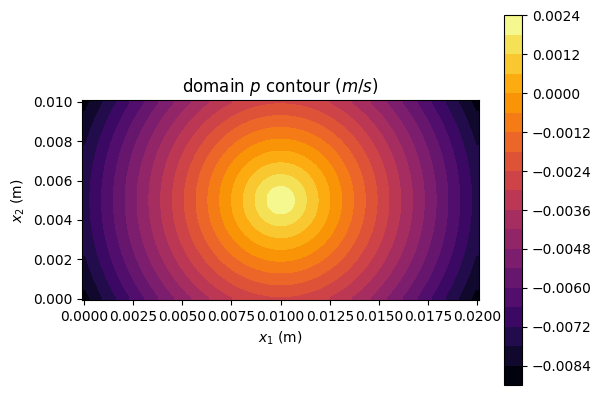

In [177]:
plt.contourf(cell_cent_x, cell_cent_y, cell_cent_phinn, 20, cmap='inferno')
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $p$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

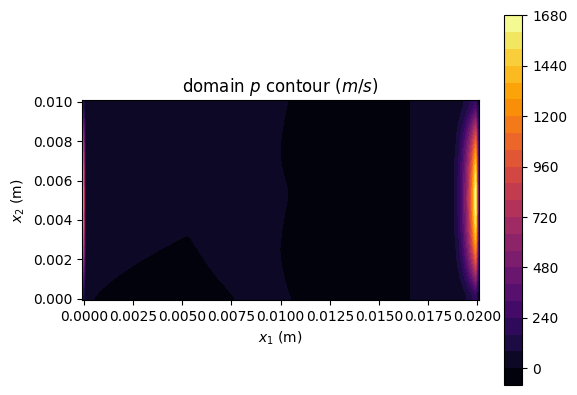

In [178]:
plt.contourf(cell_cent_x, cell_cent_y, cell_cent_pnn, 20, cmap='inferno')
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $p$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

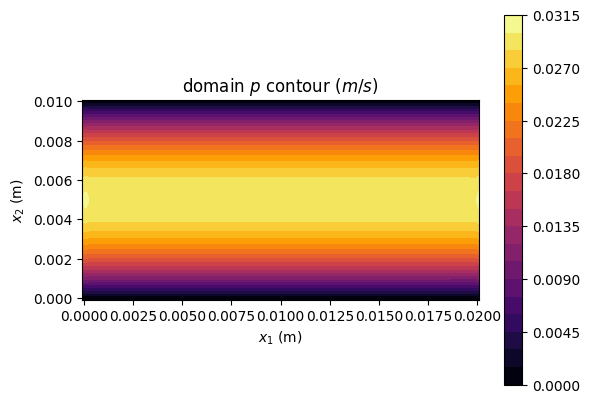

In [179]:
plt.contourf(cell_cent_x, cell_cent_y, cell_S_x_un, 20, cmap='inferno')
plt.colorbar()
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.title('domain $p$ contour ($m/s$)')
plt.gca().set_aspect('equal')
plt.show()

In [68]:
lvlset_init(-0.0003333333, -0.0003333333)

-0.017808380481256835

In [ ]:





cell_S_x_unn=unn_looper(cell_S_x_us, cell_cent_pnn, cell_S_x_unn, cell_cent_rho)
cell_S_x_unn=unn_BC_looper(cell_S_x_unn)
cell_S_x_un=cell_S_x_unn

cell_cent_phinn=phinn_looper(cell_cent_phin,cell_cent_phinn)
cell_cent_phinn=phinn_BC_looper(cell_cent_phinn)


cell_cent_x[i,j]
cell_cent_phi_ds=phi_ds_looper(cell_cent_phi_dn, cell_cent_phi_ds)
cell_cent_phi_ds=phi_ds_BC_looper(cell_cent_phi_ds)

cell_cent_phin=cell_cent_phi_dn
tau=0.0
while tau<=M*h:
    cell_cent_phin=cell_cent_phi_dn
    tau+=dtau  
    for j in range(0, Nx2+2):
        for i in range(0, Nx1+2):
            cell_cent_rho[i,j]=rho_distr(i,j)
            cell_cent_mu[i,j]=mu_distr(i,j)
cell_S_x_un=cell_S_x_unn
cell_cent_phin=cell_cent_phinn
#level-set redistancing
n_iter+=1

In [ ]:
plt.imshow(cell_cent_pn.T)

In [ ]:
n_iter